In [3]:
import tensorflow as tf
import os

# Detect and initialize TPU (if available)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU")
except ValueError:
    strategy = tf.distribute.MirroredStrategy()  # Default strategy for CPU and single GPU
    print("Running on CPU or GPU")

BATCH_SIZE = 128 * strategy.num_replicas_in_sync  # Adjust batch size for TPU


Running on CPU or GPU


In [4]:
import shutil

# Specify the path to your zip file and the directory where you want to extract it
zip_file_path = "/content/drive/MyDrive/archive (1).zip"
extraction_path = "/content/dataset"

# Extract the zip file
shutil.unpack_archive(zip_file_path, extraction_path, format="zip")


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [6]:
train_dir = "/content/dataset/Train"
test_dir = "/content/dataset/Test"

In [7]:
SEED = 12
IMG_HEIGHT = 64
IMG_SHAPE = 64
BATCH_SIZE = 128
EPOCHS = 5
LR = 0.00003

In [8]:
crime_types = os.listdir(train_dir)
n = len(crime_types)
print("Number of crime categories:", n)

Number of crime categories: 14


In [9]:
crimes = {}
train = test = 0
for clss in crime_types:
    num = len(os.listdir(os.path.join(train_dir, clss)))
    train += num
    test += len(os.listdir(os.path.join(test_dir, clss)))
    crimes[clss] = num

Text(0.5, 1.0, 'Train and Test Images')

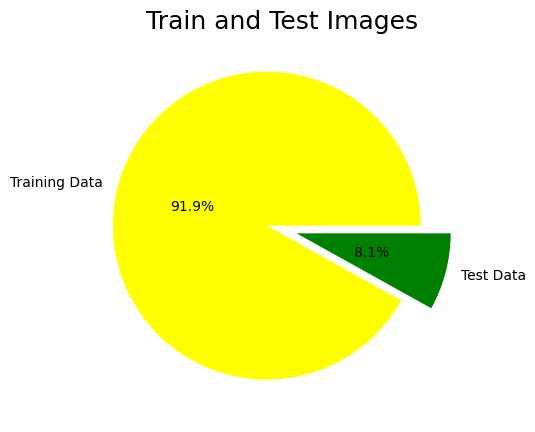

In [10]:
plt.figure(figsize=(8, 5))
plt.pie(x=np.array([train, test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5, colors=['yellow', 'green'])
plt.title("Train and Test Images", fontsize=18)


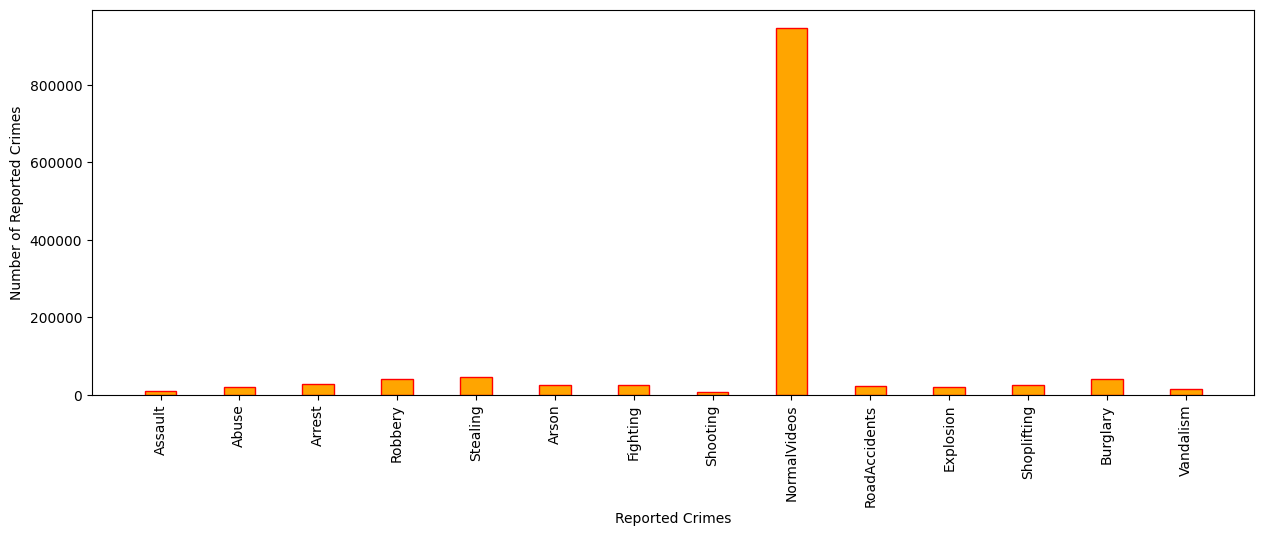

In [11]:
plt.figure(figsize=(15, 5))
plt.bar(list(crimes.keys()), list(crimes.values()), width=0.4, align="center", edgecolor=['red'], color=['orange'])
plt.xticks(rotation=90)
plt.xlabel("Reported Crimes")
plt.ylabel("Number of Reported Crimes")
plt.show()

In [12]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH)
seed = 69
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

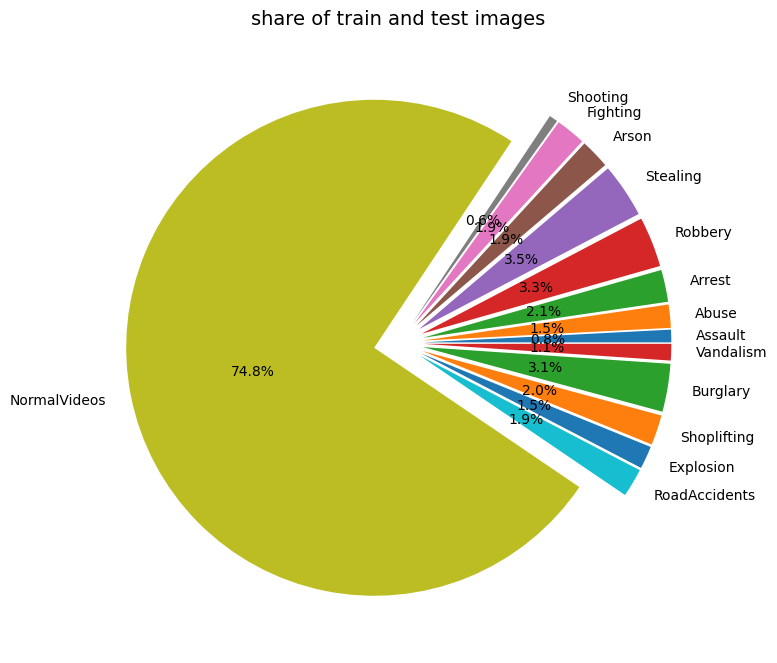

In [13]:
plt.figure(figsize=(8, 12))
plt.pie(x=np.array(list(crimes.values())), autopct="%.1f%%", explode=[0.1] * n, labels=list(crimes.keys()), pctdistance=0.5)
plt.title("share of train and test images", fontsize=14);

In [14]:
train_set = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=seed,
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.
Found 111308 files belonging to 14 classes.
Using 22261 files for validation.
Found 111308 files belonging to 14 classes.


In [15]:
def transfer_learning():
    base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet")

    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False

    for layers in base_model.layers[thr:]:
        layers.trainable=True

    return base_model

In [16]:
def create_model():
    model = Sequential()

    base_model = DenseNet121(include_top=False, input_shape=INPUT_SHAPE, weights="imagenet")

    thr = 149
    for layer in base_model.layers[:thr]:
        layer.trainable = False

    for layer in base_model.layers[thr:]:
        layer.trainable = True

    model.add(base_model)



    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(n, activation="softmax", name="classification"))

    # Load the pre-trained weights for the base model
    # base_model.load_weights('/content/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5')
    model.summary()
    return model

In [17]:
model = create_model()

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics = ['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

In [19]:
history = model.fit(x = train_set, validation_data = val_set, epochs = EPOCHS)

Epoch 1/5
7915/7915 [==============================] - 1232s 155ms/step - loss: 0.0130 - accuracy: 0.9970 - val_loss: 5.1870 - val_accuracy: 0.4625
Epoch 2/5
7915/7915 [==============================] - 1213s 153ms/step - loss: 0.0128 - accuracy: 0.9971 - val_loss: 4.0538 - val_accuracy: 0.5393
Epoch 3/5
7915/7915 [==============================] - 1214s 153ms/step - loss: 0.0120 - accuracy: 0.9973 - val_loss: 4.3758 - val_accuracy: 0.5305
Epoch 4/5
7915/7915 [==============================] - 1254s 158ms/step - loss: 0.0111 - accuracy: 0.9975 - val_loss: 4.2464 - val_accuracy: 0.5459
Epoch 5/5
7915/7915 [==============================] - 1229s 155ms/step - loss: 0.0110 - accuracy: 0.9976 - val_loss: 6.0395 - val_accuracy: 0.4683


In [20]:
model.save('crime.h5')


In [21]:
from tensorflow.keras.models import load_model
model.load_weights('crime.h5')

In [22]:
y_true = np.array([])

for x,y in test_set:
    y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [23]:
y_pred=model.predict(test_set)

870/870 [==============================] - 57s 63ms/step


In [24]:
y_pred

array([[7.7130538e-03, 1.1574435e-02, 2.3453156e-03, ..., 4.9479457e-04,
        6.1894613e-03, 1.1499799e-01],
       [5.5388920e-03, 2.0906860e-02, 4.5697865e-04, ..., 1.9004296e-04,
        2.4308604e-03, 1.0492228e-02],
       [1.4095119e-02, 6.8805595e-03, 6.0218835e-04, ..., 3.2131953e-04,
        3.0972352e-03, 2.9740321e-02],
       ...,
       [1.1731966e-05, 1.8849754e-04, 1.4537560e-05, ..., 5.6995714e-07,
        4.6256879e-05, 1.8961275e-05],
       [4.2007807e-05, 4.0364932e-04, 6.0237024e-05, ..., 1.9863826e-06,
        1.2499424e-04, 8.0704500e-05],
       [6.9011594e-06, 9.0098132e-05, 1.0846182e-05, ..., 3.1947391e-07,
        3.7604150e-05, 1.3271669e-05]], dtype=float32)

In [ ]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [25]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [26]:
model= load_model('crime.h5')

In [ ]:
#testing 1
img = image.load_img('/content/dataset/Test/RoadAccidents/RoadAccidents001_x264_10.png',target_size=(64,64)) #Reading image
x = image.img_to_array(img) # converting image into array
x = np.expand_dims(x,axis=0) # expanding Dimensions
pred = np.argmax(model.predict(x)) #Predicting the higher probability index
op = ['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred] #List indexing with output

1/1 [==============================] - 2s 2s/step


'RoadAccident'

In [27]:
#testing 2
img = image.load_img('/content/dataset/Test/Explosion/Explosion002_x264_10.png',target_size=(64,64)) #Reading image
x = image.img_to_array(img) # converting image into array
x = np.expand_dims(x,axis=0) # expanding Dimensions
pred = np.argmax(model.predict(x)) #Predicting the higher probability index
op = ['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred] #List indexing with output

1/1 [==============================] - 3s 3s/step


'Explosion'

In [ ]:
#testing 3
img = image.load_img('/content/dataset/Test/Abuse/Abuse028_x264_10.png',target_size=(64,64)) #Reading image
x = image.img_to_array(img) # converting image into array
x = np.expand_dims(x,axis=0) # expanding Dimensions
pred = np.argmax(model.predict(x)) #Predicting the higher probability index
op = ['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred] #List indexing with output

1/1 [==============================] - 0s 73ms/step


'Abuse'

In [28]:
#testing 4
img = image.load_img('/content/dataset/Test/Robbery/Robbery048_x264_0.png',target_size=(64,64)) #Reading image
x = image.img_to_array(img) # converting image into array
x = np.expand_dims(x,axis=0) # expanding Dimensions
pred = np.argmax(model.predict(x)) #Predicting the higher probability index
op = ['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred] #List indexing with output

1/1 [==============================] - 0s 33ms/step


'Robbery'

In [29]:
#testing 5
img = image.load_img('/content/dataset/Test/Burglary/Burglary005_x264_10.png',target_size=(64,64)) #Reading image
x = image.img_to_array(img) # converting image into array
x = np.expand_dims(x,axis=0) # expanding Dimensions
pred = np.argmax(model.predict(x)) #Predicting the higher probability index
op = ['Fighting','Arrest','Vandalism','Assault','Stealing','Arson','NormalVideos','Burglary','Explosion','Robbery','Abuse','Shooting','Shoplifting','RoadAccident']
op[pred] #List indexing with output

1/1 [==============================] - 0s 48ms/step


'Burglary'